In [1]:
from sklearn.datasets import fetch_openml
from sklearn import svm, datasets
from sklearn.metrics import (auc, accuracy_score, precision_score, recall_score,
                             f1_score, hinge_loss, plot_roc_curve, roc_curve,
                             roc_auc_score, plot_precision_recall_curve,
                             precision_recall_curve)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

# Klasyfikatory SVM

Zadaniem klasyfikatora SVM jest znalezienie hiperpłaszczyzny w N wymiarowej przestrzeni (gdzie N to liczba cech), która jak najlepiej przydziela podanym punktom klasy.
- dla N = 1, hiperpłaszczyzną będzie punkt
- dla N = 2, będzie to zwykła linia prosta
- dla N = 3, będzie to płaszczyzna
- .....

Klasyfikator SVM potrafi jedynie rozdzielić punkty na dwie klasy.

Istnieje wile hyperpłaszczyzn (na rysunku N = 2 => linia), które poprawnie przydzialą klasy poszczególnym punktom

![title](./gfx/possible_lines.png)

ale nas interesuje ta linia, która, ma optymalny margines:

![title](./gfx/optimal_margin.png)

Margines wybieramy za pomocą metody zwanej Cross-Validation (o której więcej napisane jest niżej).

W SVM używamy soft-margin, czyli pozwalamy na niepoprawną klasyfikację niektórych punktów, o ile opłaci się to w przyszłoci.

Przykład:


<img src="./gfx/soft_margin.png" width="80%">

W powyższym przykładzie, pozwalamy na to, żeby jedna czerwona kropka były zaklasyfikowana jako zielona, bo zostawiamy więcej miejsca na przyszłe kropki, które będziemy chcieli sklasyfikować. 

W Cross-Validation ustalamy ile błędnych pomiarów pozwalamy wewnątrz soft-margin.

Dużą zaletą SVM jest to, że potrafi on poprawnie klasyfikować dane, które nie są liniowe.

Przykład: Mamy dane jaka dawka leku potrafi skutecznie wyleczyć pacjentów. Nie może być to dawka zbyt mała i zbyt duża:

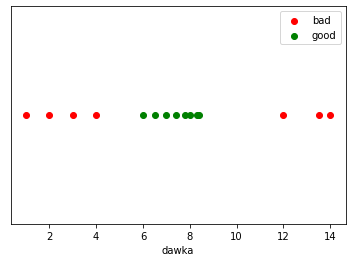

In [2]:
bad_dosages = np.array([1,2,3,4,12,13.5,14])
good_dosages = np.array([6,6.5,7,7.4,7.8,8,8.3,8.4])
plt.scatter(x=bad_dosages, y=[1]*len(bad_dosages),c='red',label='bad')
plt.scatter(x=good_dosages, y=[1]*len(good_dosages),c='green',label='good')
plt.yticks([])
plt.xlabel('dawka')
plt.legend()

Widzimy, że klasyfikator liniowy, nie jest w stanie poprawnie oddzielić czerwoych i zielonych kropek.

Ale w SVM, wybierzemy N = 2 (czyli zwiększymy wymiarowosć danych), podniesiemy do kwadratu wartosci dawkowania (z osi OX)
i dzięki temu, będziemy już w stanie poprawnie zaklasyfikować dawkowanie:

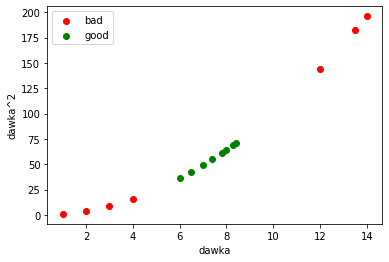

In [3]:
bad_s = bad_dosages**2
good_s = good_dosages**2
plt.scatter(x=bad_dosages, y=bad_s,c='red',label='bad')
plt.scatter(x=good_dosages, y=good_s,c='green',label='good')
plt.xlabel('dawka')
plt.ylabel('dawka^2')
plt.legend()

Dzięki temu zabiegowi, jestesmy w stanie znaleźć prostą, oddzielającą czerwone i zielone punkty

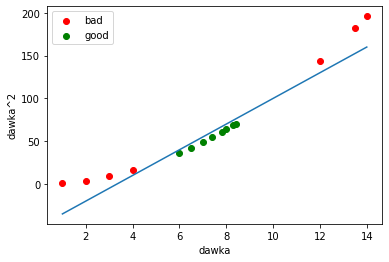

In [4]:
a = 15
b = -50

xs = np.array(list(range(1,15)))

plt.scatter(x=bad_dosages, y=bad_s,c='red',label='bad')
plt.scatter(x=good_dosages, y=good_s,c='green',label='good')
plt.xlabel('dawka')
plt.ylabel('dawka^2')
plt.plot(xs, xs*a+b, '-')
plt.legend()


## Kernel Trick

Zapewne zastanawiacie się co decyduje o tym jakiej transformacji dokonujemy na danych aby otrzymać stosowny SVC. Dlaczego coś jest np. podnoszone do kwadratu a nie logarytmowane czy mnożone razy 7?
Z pomocą przychodzą tutaj tzw. *kernel functions*, które powzwalają na systematyczne znajdywanie SVC w wyższych wymiarach. Istnieje wiele rodzajów kerneli (liniowy, wielomianowy, radialny...).

Weźmy na przykład kernel wielomianowy, który jako parametr przyjmuje stopień wielomianu. Działa on w następujący sposób:
Mając dane *d* (stopień wielomianu) oblicza *d-wymiarowe* relacje pomiędzy każdą parą obserwacji, a następnie na ich podstawie znajduje odpowiedni SVC.
Tak więc jeśli d = 1, kernel zbada relacje pomiędzy wszystkimi parami w przestrzeni 1D:

![1D-relationship-comparition](./gfx/kernel_ex.svg)

I wyznaczy na ich podstawie SVC:

![1D-SVC](./gfx/kernel_ex2.svg)

Tak samo dla d = 2, 3, ...

Jednak transformacja zbiorów danych do wyższych wymiarów jest bardzo kosztowna. Dlatego też używany jest tzw. __*Kernel Trick (trik kernelowy)*__, który umożliwia obliczanie relacji wysokowymiarowych bez faktycznego przekształcania danych do wyższych wymiarów

## Cross-validation

### ROC

Krzywa ROC to jeden ze sposobów wizualizacji jakości klasyfikacji, pokazujący zależności wskaźników TPR (True Positive Rate) oraz FPR (False Positive Rate).
Im wykres bardziej ”wypukły”(bardziej wygięty ku górnemu lewemu narożnikowi), tym lepszy klasyfikator.
Przekątna odpowiada losowemu „zgadywaniu”.


![ROC](./gfx/roc2.png)
    

### Ocena klasyfikatora na podstawie ROC

Jakość klasyfikacji za pomocą krzywej ROC można ocenić wyliczając takie wskaźniki jak:
- pole pod krzywą (AUC) (Area Under ROC Curve)
    - Im większe AUC tym lepiej: AUC = 1 (klasyfikator idealny), AUC = 0.5 (klasyfikator losowy), AUC < 0.5 (nieprawidłowy klasyfikator (gorszy niż losowy)).
- współczynnik Giniego: GC = 2*AUC-1 (wyższość klasyfikatora nad losowym).
    - Im większy GC tym lepiej: GC = 1 (klasyfikator idealny), GC = 0 (klasyfikator losowy).

### Precision-Recall
- Za dokładność rozpoznania w obrębie klasy odpowiada miara precision.
    - jest to stosunek poprawnie sklasyfikowanych elementów (True Positive) do wszystkich, które nasz klasyfikator oznaczył jako poprawne (True Positive + False Positive)
- Za rozpoznanie ilości elementów z klasy odpowiada miara recall.
    - jst to stosunek poprawnie rozpoznanych elementów (TP) do wszystkich, które powinien rozpoznać (TP+FN)
    
![](./gfx/Precisionrecall.svg)

### F1 score
Jest to miara łącząca w sobie Precision i Recall. Miara ta jest pomocna do znalezienia równowagi pomiędzy precyzją a recall.

Sprawa jest prosta, gdy wszystkie wartości są dla jednego z nich większe, ale co w sytuacji, gdy w jednym większe jest precision, a w drugim recall.
Rozwiazaniem może być uśrednienie wyniku, niestety zwykła śrendia arytmetyczna nie oddaje dobrze różnic pomiędzy klasyfikatorami. 
Najlepszym rozwiązaniem będzie zastosowanie śrendiej harmonicznej:

![](./gfx/formula.png)

Beta jest parametrem, który określa "ważność" danej miary:
- precision i recall tak samo ważne
- β=0.5 precision ważniejsze
- β=2 recall ważniejszy

# Prezentacja działania SVM na zbiorze WBC

### Przygotowanie zbioru

In [5]:
cancer = datasets.load_breast_cancer()

Dane to 30 kolumn opisujące każdy przypadek

In [6]:
print(cancer.feature_names)

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [7]:
print(cancer.target_names)

['malignant' 'benign']


In [8]:
X, Y = cancer.data, cancer.target

x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.8)

def fit_model(data_x, data_y,kernel='linear' ):
    clf = svm.SVC(kernel=kernel)
    clf.fit(data_x,data_y)
    return clf


def calculate_using(kernel='linear'):
    clf = fit_model( x_train, y_train, kernel)
    y_pred = clf.predict(x_test)
    
    a_score = accuracy_score(y_test,y_pred)
    cv_scores = cross_val_score(clf, X, Y, cv=5)
    h_loss = hinge_loss(y_test, y_pred)
    p_score = precision_score(y_test, y_pred)
    r_score = recall_score(y_test, y_pred)
    f_score = f1_score(y_test, y_pred)
    
    single_scored = {
        'accuracy_score': a_score,
        'hinge_loss': h_loss,
        'precission_score': p_score,
        'recall_score': r_score,
        'f1_score': f_score
    }
    
    return single_scored, cv_scores

In [9]:
def get_kernel_scores(kernel_name, frame_data, cv_data):
    single_scored, cv = calculate_using(kernel_name)
    frame_data.append([kernel_name] + list(single_scored.values()))
    cv_data.append([kernel_name] + list(cv))

### Obliczanie wynikow dla kerneli (liniowy, wielomianowy, rbf)

In [10]:
frame_data = []
cv_data = []
get_kernel_scores('linear', frame_data, cv_data)
get_kernel_scores('poly', frame_data, cv_data)
get_kernel_scores('rbf', frame_data, cv_data)

In [11]:
frame = pd.DataFrame(frame_data, columns=["kernel", "accuracy_score", "hinge_loss", "precission_score", "recall_score", "f1_score"])
frame

,kernel,accuracy_score,hinge_loss,precission_score,recall_score,f1_score
0,linear,0.938596,0.403509,0.947368,0.96,0.953642
1,poly,0.903509,0.438596,0.900000,0.96,0.929032
2,rbf,0.903509,0.438596,0.900000,0.96,0.929032


In [12]:
cv_frame = pd.DataFrame(cv_data, columns=["kernel", "cv score 1", "cv score 2", "cv score 3", "cv score 4", "cv score 5"])
cv_frame

,kernel,cv score 1,cv score 2,cv score 3,cv score 4,cv score 5
0,linear,0.947368,0.929825,0.973684,0.921053,0.955752
1,poly,0.842105,0.885965,0.929825,0.947368,0.938053
2,rbf,0.850877,0.894737,0.929825,0.947368,0.938053


### Krzywe ROC i PR dla kernela wielomianowego

In [13]:
clf = fit_model(x_train, y_train, kernel='poly')

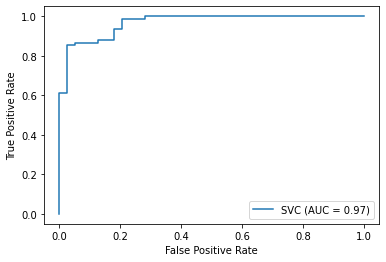

In [14]:
plot_roc_curve(clf, x_test, y_test)

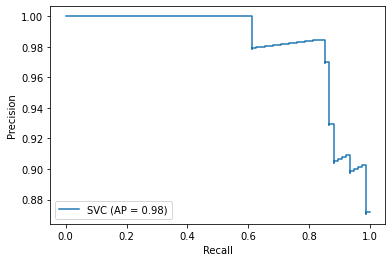

In [15]:
plot_precision_recall_curve(clf , x_test, y_test)

### Powierzchnie pod krzywymi

In [16]:
y_pred = clf.predict(x_test)

roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, _ = precision_recall_curve(y_test,  y_pred)

pr_auc = auc(fpr, tpr)

print(f"Area under ROC: {roc_auc}")
print(f"Area under PR: {pr_auc}")

Area under ROC: 0.8774358974358976
Area under PR: 0.2852631578947368


# Wyniki z metodą PCA

In [17]:
scaler = StandardScaler()

scaler.fit(X)

#normalizacja cech
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)
x_scaled = scaler.transform(X)

#### Podgląd całego zbioru danych używając metody PCA

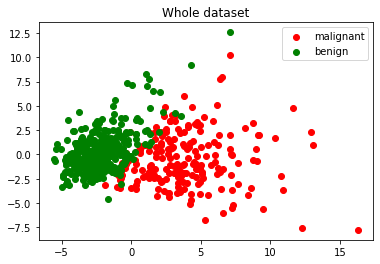

In [18]:
pca = PCA(n_components=2)
pca.fit(x_scaled)

reduced_x = pca.transform(x_scaled)
indexes_0 = Y == 0
indexes_1 = Y == 1


plt.scatter(reduced_x[indexes_0,0], reduced_x[indexes_0, 1], color = "red",label='malignant')
plt.scatter(reduced_x[indexes_1,0], reduced_x[indexes_1, 1], color = "green", label='benign')
plt.title("Whole dataset")
plt.legend()
plt.show()
plt.close()

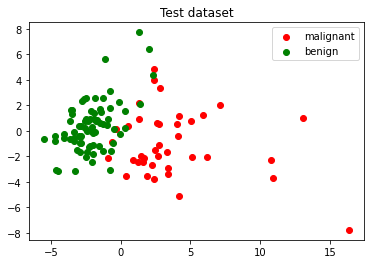

In [19]:

reduced_x_test = pca.transform(x_test_scaled)
indexes_0_test = y_test == 0
indexes_1_test = y_test == 1


plt.scatter(reduced_x_test[indexes_0_test,0], reduced_x_test[indexes_0_test, 1], color = "red",label='malignant')
plt.scatter(reduced_x_test[indexes_1_test,0], reduced_x_test[indexes_1_test, 1], color = "green", label='benign')
plt.title("Test dataset")
plt.legend()
plt.show()
plt.close()

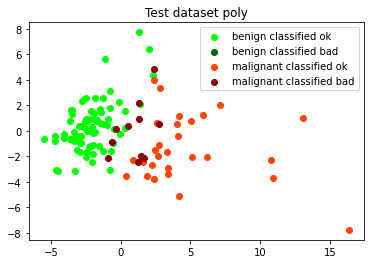

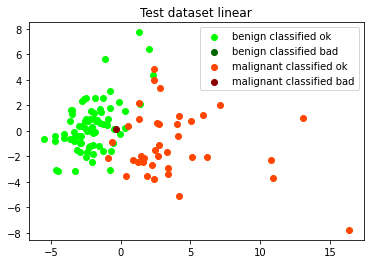

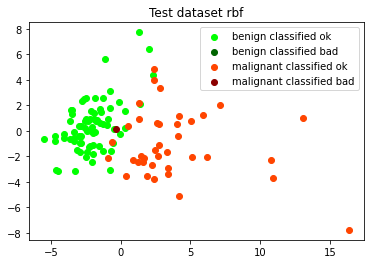

In [20]:
kernels = ['poly', 'linear', 'rbf']

indexes_0_test = y_test == 0
indexes_1_test = y_test == 1

for ker in kernels:
    model = fit_model(x_train_scaled, y_train, ker)
    model_y = model.predict(x_test_scaled)
    
    model_y_0 = model_y == 0
    model_y_1 = model_y == 1
    
    good_model_0 = model_y_0 & indexes_0_test
    bad_model_0 = (~good_model_0) & indexes_0_test
    
    
    good_model_1 = model_y_1 & indexes_1_test
    bad_model_1 = (~good_model_1) & indexes_1_test 
    

    
    plt.scatter(reduced_x_test[good_model_1,0], reduced_x_test[good_model_1, 1], color = "lime",label='benign classified ok')
    plt.scatter(reduced_x_test[bad_model_1,0], reduced_x_test[bad_model_1, 1], color = "darkgreen",label='benign classified bad')
    plt.scatter(reduced_x_test[good_model_0,0], reduced_x_test[good_model_0, 1], color = "orangered",label='malignant classified ok')
    plt.scatter(reduced_x_test[bad_model_0,0], reduced_x_test[bad_model_0, 1], color = "darkred",label='malignant classified bad')
    plt.title("Test dataset " + ker)
    plt.legend()
    plt.show()
    plt.close()
    
    

# Zadania

In [21]:
mnist = fetch_openml("mnist_784", data_home="./mnist_784")

### Zadanie 1

Na wybranych przez prowadzących tutorial zbiorach danych dokonać klasyfikacji metodą SVM dla różnych kerneli, oraz klasyfikacji metodą k-NN dla k=1,3 i 5. 
Podglądnąć otrzymane wyniki przy pomocy PCA.  
Skomentować otrzymane wyniki.  

In [22]:
mnist_zipped = list(zip(mnist.data, mnist.target))
mnist_random_sample = random.sample(mnist_zipped, len(mnist.data))
X, Y = zip(*(mnist_random_sample))
X = np.asarray(X)
Y = np.asarray(Y)

x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.9)

In [23]:
# TODO 

# For linear kernel

# For polymian kernel

# For radial kernel

##### MIEJSCE NA TWÓJ KOMENTARZ

### Zadanie 2
Zrobić to samo, ale redukując wcześniej wymiarowość danych metodą PCA z 784 do 30. 
Czy wyniki uległy poprawie? Jeżeli tak (nie) to dlaczego? Skomentować otrzymane wyniki

In [24]:
# TODO 

# PCA for 30 element

# For linear kernel

# For polymian kernel

# For radial kernel

##### MIEJSCE NA TWÓJ KOMETARZ